In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re

%matplotlib inline

from helpers.readers import read_dataframe
#from helpers.utils import cast_back_to_int64, downcast_int64

In [2]:
cmu_scraped_movies = read_dataframe(name='cmu/movies_scraped')
cmu_scraped_movies.head(1)

,Wikipedia movie ID,Directed by,Screenplay by,Story by,Based on,Produced by,Starring,Cinematography,Edited by,Music by,Production company,Distributed by,Release dates,Running time,Country,Language,Budget,Box office
0,975900,John Carpenter,<NA>,<NA>,<NA>,Sandy King,Ice Cube Natasha Henstridge Jason Statham Pam ...,Gary B. Kibbe,Paul C. Warschilka,John Carpenter,<NA>,Sony Pictures Releasing,<NA>,98 minutes,United States,English,$28 million,$14 million


In [3]:
columns_to_drop = [
    'Directed by', 'Screenplay by', 'Story by', 
    'Based on', 'Produced by', 'Starring', 'Cinematography', 
    'Edited by', 'Music by', 'Production company', 'Distributed by'
]

cmu_scraped_movies = cmu_scraped_movies.drop(columns=columns_to_drop)

cmu_scraped_movies.head(1)

,Wikipedia movie ID,Release dates,Running time,Country,Language,Budget,Box office
0,975900,<NA>,98 minutes,United States,English,$28 million,$14 million


# Runtime parsing

In [4]:
cmu_scraped_movies["Running time"].count(), len(cmu_scraped_movies) # non NaN entries (77%)

#tot = cmu_scraped_movies["Running time"].unique()
#for x in tot:
#    print(x)

(63508, 81741)

In [5]:
cmu_scraped_movies[cmu_scraped_movies["Running time"].str.contains("reels")]

,Wikipedia movie ID,Release dates,Running time,Country,Language,Budget,Box office
105,18109665,<NA>,2 reels (20 minutes),United States,Silent with English intertitles,<NA>,<NA>
130,30002176,<NA>,"9 reels; 7,459 feet",United States,<NA>,<NA>,<NA>
218,29146560,<NA>,6 reels ; 74 minutes (USA) 65 minutes (DVD),United States,Silent (English intertitles ),<NA>,<NA>
276,18037577,<NA>,2 reels,United States,Silent with English intertitles,<NA>,<NA>
451,7731853,<NA>,73 minutes (8 reels),United States,Silent (English intertitles ),<NA>,<NA>
...,...,...,...,...,...,...,...
81205,7223276,<NA>,2 reels,United States,Silent (English intertitles ),<NA>,<NA>
81322,13080060,<NA>,2 reels,United States,Silent (English intertitles ),<NA>,<NA>
81343,12976553,<NA>,2 reels,United States,Silent,<NA>,<NA>
81385,18207591,<NA>,5 reels,United States,Silent (English intertitles ),<NA>,<NA>


In [6]:
def parse_runtime(runtime):
    if pd.isna(runtime):
        return None
    
    # https://en.wikipedia.org/wiki/Reel
    if 'reels' in runtime:
        match = re.search(r'(\d+) reels', runtime)
        if match:
            return int(match.group(1)) * 10
        
    if 'reel' in runtime:
        match = re.search(r'(\d+) reel', runtime)
        if match:
            return int(match.group(1)) * 10

    if 'feet' in runtime:
        match = re.search(r'(\d+) feet', runtime)
        if match:
            return int(match.group(1)) / 1000 * 11

    if 'hour' in runtime or 'hr' in runtime:
        hours = re.search(r'(\d+) hour', runtime)
        hours = int(hours.group(1)) if hours else 0
        minutes = re.search(r'(\d+) min', runtime)
        minutes = int(minutes.group(1)) if minutes else 0
        return hours * 60 + minutes

    if 'Min' in runtime:
        match = re.search(r'(\d+) Min', runtime)
        if match:
            return int(match.group(1))
        
    if 'seconds' in runtime:
        match = re.search(r'(\d+) seconds', runtime)
        if match:
            return int(match.group(1)) / 60
        
    if 'secs' in runtime:
        match = re.search(r'(\d+) secs', runtime)
        if match:
            return int(match.group(1)) / 60
    
    if 'minute' in runtime or 'min' in runtime or "'" in runtime:
        minute_patterns = [r'(\d+)\s*min', r'(\d+)\s*minute', r"(\d+)'"]
        for pattern in minute_patterns:
            match = re.search(pattern, runtime)
            if match:
                return int(match.group(1))
            
    if ':' in runtime:
        try:
            minutes, seconds = runtime.split(':')
            return int(minutes) + int(seconds) / 60
        except ValueError:
            pass
        
    hour_minute_patterns = [r'(\d+)h\s*(\d+)m', r'(\d+)\.(\d+)']
    for pattern in hour_minute_patterns:
        match = re.search(pattern, runtime)
        if match:
            hours, minutes = match.groups()
            return int(hours) * 60 + int(minutes)

    if ':' in runtime and runtime.count(':') == 1:
        try:
            minutes, seconds = runtime.split(':')
            return int(minutes) + int(seconds) / 60
        except ValueError:
            pass  
        
    if ':' in runtime and runtime.count(':') == 2:
        try:
            hours, minutes, seconds = runtime.split(':')
            return int(hours) * 60 + int(minutes) + int(seconds) / 60
        except ValueError:
            pass

    return None

cmu_scraped_movies['runtime_minutes'] = cmu_scraped_movies['Running time'].apply(parse_runtime)

In [7]:
#tot = cmu_scraped_movies[(cmu_scraped_movies['Running time'].notna()) & (cmu_scraped_movies['runtime_minutes'].isna())]["Running time"]
#for x in tot:
#    print(x)

cmu_scraped_movies["Running time"].count() - cmu_scraped_movies["runtime_minutes"].count() # on 60k only 400 not parsed

397

In [8]:
#cmu_scraped_movies[['Running time', 'runtime_minutes']].to_csv('cmu_movies_runtime.csv', index=False)

cmu_scraped_movies[['Running time', 'runtime_minutes']]

,Running time,runtime_minutes
0,98 minutes,98.0
1,44–45 minutes,45.0
2,83 minutes,83.0
3,111 minutes,111.0
4,106 minutes,106.0
...,...,...
81736,90 minutes,90.0
81737,96 minutes,96.0
81738,66 min,66.0
81739,<NA>,NaN


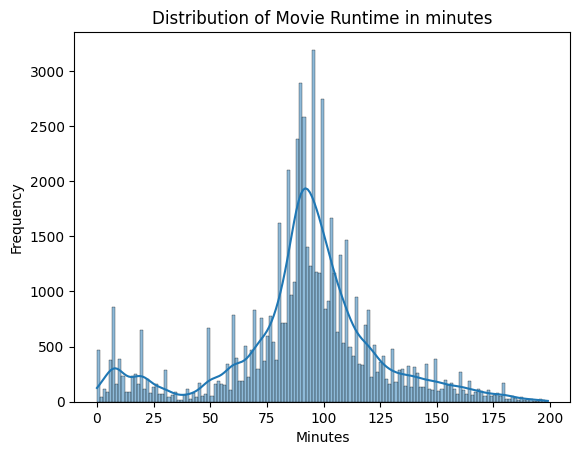

In [9]:
sns.histplot(cmu_scraped_movies[cmu_scraped_movies['runtime_minutes'] < 200]["runtime_minutes"].dropna(), kde=True)
plt.xlabel('Minutes')
plt.ylabel('Frequency')
plt.title('Distribution of Movie Runtime in minutes')
plt.show()

# Revenue parsing

In [11]:
tot = cmu_scraped_movies["Box office"].unique()
for x in tot:
    print(x)

$14 million
<NA>
$3.6 million (worldwide rentals)
Lady Snowblood: Love Song of Vengeance
$10.2 million
$103.1 million
$21,521
$29.3 million
$932,000
$878,819 (Australia)
HK$1,627,031.00
R 1.8 billion (~ $200 million )
$605,731
$11.2 million
$ 3,416,846 (USA)
$172,055
$4 million (US)
CAD $5 million
$4 million (U.S. and Canada rentals)
$3.6 million
$8 million
$17.8 million
₹ 45.13 crore
$ 870 504
US$4,736,013
$33.3 million
$638,181
$4 million (US) $10 million (worldwide) $4.2 million (rentals)
$4.7 million
US$1,400,000
$529,677
$45 million
$351,447 (North America)
$11.1 million
$8 million (rentals)
$879,794 (domestic)
$9.53 million
$665,523
$366.2 million
$1,068,682
$294,900 49,150 admissions (France)
$1,096,000
ESP 116.7 million ( USD$ 901,508)
$1,791,000
$39.4 million
$10.6 million
$35 million
$47 million
₱17.6 million
$1.8 million
$128 million
$300.5 million
$14,598,571
₹ 35-45 million
$44.5 million
159,429 $
$26.3 million (US)
$1.4 million (US rentals)
SEK 3,749,000 (Sweden)
$153.4 m

In [89]:
def currency_symbol_to_code(text):
    currency_map = {
        '€': 'EUR', 'eur': 'EUR', 'euros': 'EUR',
        '$': 'USD', 'USD': 'USD', 'dollar': 'USD',
        '₹': 'INR', 'Rs': 'INR', 'Rp': 'INR', 'rupee': 'INR',
        '£': 'GBP', 'GPD': 'GBP',
        '¥': 'CNY', 'renminbi': 'CNY', 'yuan': 'CNY',
        '₽': 'RUB', 'RUR': 'RUB', 'rubles': 'RUB', 'RUB': 'RUB',
        'IRR': 'IRR', 'rial': 'IRR', 'Rial': 'IRR', 'rials': 'IRR',
        'real': 'BRL',
        'SEK' : 'SEK',
        '₱': 'PHP', 
        '₤': 'ITL', 'L.': 'ITL', 'Italian lire' : 'ITL',
        'yen': 'JPY', 'Yen' : 'JPY',
        'CZK' : 'CZK',
        'AUD' : 'AUD',
    }
    for key, value in currency_map.items():
        if key in text:
            return value
    return None

def parse_revenue(revenue):
    if pd.isna(revenue):
        return None, None

    revenue = re.sub(r'(est\.|c\.)\s*', '', revenue).replace(',', '')

    # Identify currency first
    currency = currency_symbol_to_code(revenue)

    # Match and convert numbers
    match = re.search(r'(\d+(?:\.\d+)?)\s*(billion|million|crore)?', revenue, re.IGNORECASE)
    if match:
        value, multiplier = match.groups()

        if multiplier:
            if 'million' in multiplier.lower():
                value = convert_million(value)
            elif 'billion' in multiplier.lower():
                value = convert_billion(value)
            elif 'crore' in multiplier.lower():
                value = convert_crore(value)
        else:
            value = parse_number(value)

        return currency, float(value)

    return None, None

cmu_scraped_movies['revenue_currency'], cmu_scraped_movies['revenue_value'] = zip(*cmu_scraped_movies['Box office'].apply(parse_revenue))

In [90]:
print(cmu_scraped_movies["Box office"].count())
print(cmu_scraped_movies["Box office"].count() - cmu_scraped_movies["revenue_currency"].count())
print(cmu_scraped_movies["Box office"].count() - cmu_scraped_movies["revenue_value"].count())

547
15


In [92]:
#cmu_scraped_movies[cmu_scraped_movies["Box office"].notna()][["Country","Box office", "revenue_value", "revenue_currency"]]

#cmu_scraped_movies[(cmu_scraped_movies["Box office"].notna()) & (cmu_scraped_movies["revenue_currency"].isna())]
#cmu_scraped_movies[(cmu_scraped_movies["Box office"].notna()) & (cmu_scraped_movies["revenue_revenue"].isna())]

cmu_scraped_movies[(cmu_scraped_movies["Country"].str.contains("Iran")) & (cmu_scraped_movies["Box office"].notna())][["Country", "Box office", "revenue_currency", "revenue_value"]]

#cmu_scraped_movies[(cmu_scraped_movies["Box office"].notna()) & (cmu_scraped_movies["revenue_currency"].isna())].to_csv('cmu_movies_revenue.csv', index=False)

,Country,Box office,revenue_currency,revenue_value
6715,Iran,US$1.6 million,USD,1.600000e+06
23323,Iran,$3 million,USD,3.000000e+06
24120,Iran,"$879,422",USD,8.794220e+05
27911,Iran,"$220,360",USD,2.203600e+05
33813,Iran,"$344,235 (USA sub-total)",USD,3.442350e+05
37163,Iran,"$10,923",USD,1.092300e+04
67191,Iran,"$40,300",USD,4.030000e+04
76165,Iran,Over 16 million rials,IRR,1.600000e+07
77588,Iran,"Rial5,233,183,000",IRR,5.233183e+09
81284,Iran,$24.4 million,USD,2.440000e+07


# Budget

In [17]:
tot = cmu_scraped_movies["Budget"].unique()
for x in tot:
    print(x)

$28 million
<NA>
$2.8 million
$1,200,000–$2,275,000
£45,000 or £47,341
$9 million
$4.4–6 million
$3 Million
$16 million
$781,000
$4 million
$5 million
$302,976
Unknown
$500,000
$8.5 million
$4.2 million
CAD$ 179,000
$782,000 or $336,000
$1.7 million
$300,000
$73,000
$4.1 million
₹ 35 crore
$750,000
$14.32 million
US$450,000
€6,398,769
£635,000
$6 million (est)
$8 million
$1.5 million
$12 million
$1.25 million
$1,470,000
$4.5 million
$2,500
$13 million
$2.2 million or £1,055,829
$806,735
$6 million
12 million mk
$692,087
less than £300
40,000,000$
$1,103,000
$2,443,322.31
$16.5 million
$15 million
$2.3 million
$22 million
Under US$ 100,000
$55 million
£2,000,000
168 million ₧
$250,000 (£80,000)
$150,000
$25 million
₹ 80 million
$8.7 million
$500
$13.5 million
$50 million
₹ 25 crore
$31 million
4.5 crore
$125,000
$2.2 million
$7,000 ( est. )
$33 million
$2 million
$4,391,000
$24.5 million
$65,000
$12.8 million
$24 million
$7 million
$3,540,000
¥200–300 million
₹ 23.5 lakh
₹ 3 million
~ U

In [96]:
cmu_scraped_movies['budget_currency'], cmu_scraped_movies['budget_value'] = zip(*cmu_scraped_movies['Budget'].apply(parse_revenue))

In [101]:
print(cmu_scraped_movies["Budget"].count())
print(cmu_scraped_movies["Budget"].count() - cmu_scraped_movies["budget_currency"].count())
print(cmu_scraped_movies["Budget"].count() - cmu_scraped_movies["budget_value"].count())

495
53


# Generating Profit

In [109]:
def compute_profit(row):
    if (
        pd.notna(row['budget_value']) and pd.notna(row['revenue_value']) and
        row['budget_currency'] == row['revenue_currency'] and
        row['budget_currency'] is not None
    ):
        profit = row['revenue_value'] - row['budget_value']
        return profit, row['budget_currency']
    else:
        return None, None

cmu_scraped_movies[['profit_value', 'profit_currency']] = cmu_scraped_movies.apply(compute_profit, axis=1, result_type='expand')

In [113]:
cmu_scraped_movies

,Wikipedia movie ID,Release dates,Running time,Country,Language,Budget,Box office,runtime_minutes,revenue_currency,revenue_value,budget_currency,budget_value,profit_value,profit_currency
0,975900,<NA>,98 minutes,United States,English,$28 million,$14 million,98.0,USD,14000000.0,USD,28000000.0,-14000000.0,USD
1,3196793,<NA>,44–45 minutes,<NA>,<NA>,<NA>,<NA>,45.0,None,NaN,None,NaN,NaN,None
2,28463795,<NA>,83 minutes,Norway,Norwegian,<NA>,<NA>,83.0,None,NaN,None,NaN,NaN,None
3,9363483,9 May 1987 ( 1987-05-09 ) ( Cannes ) 20 May 19...,111 minutes,United Kingdom,English,$2.8 million,<NA>,111.0,None,NaN,USD,2800000.0,NaN,None
4,261236,<NA>,106 minutes,West Germany,German,<NA>,<NA>,106.0,None,NaN,None,NaN,NaN,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
81736,35228177,<NA>,90 minutes,<NA>,English,<NA>,<NA>,90.0,None,NaN,None,NaN,NaN,None
81737,34980460,<NA>,96 minutes,Ireland,<NA>,<NA>,<NA>,96.0,None,NaN,None,NaN,NaN,None
81738,9971909,<NA>,66 min,United States,English,<NA>,<NA>,66.0,None,NaN,None,NaN,NaN,None
81739,913762,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,NaN,None,NaN,None,NaN,NaN,None


In [115]:
cmu_scraped_movies[cmu_scraped_movies['profit_value'].notna()][["Box office", "Budget", "profit_value"]]

,Box office,Budget,profit_value
0,$14 million,$28 million,-1.400000e+07
7,$3.6 million (worldwide rentals),"$1,200,000–$2,275,000",2.400000e+06
13,$10.2 million,$9 million,1.200000e+06
17,$103.1 million,$4.4–6 million,1.031000e+08
29,$29.3 million,$16 million,1.330000e+07
...,...,...,...
81711,"A$21,976 (Australia)",$4 million,-3.978024e+06
81720,$15.4 million,$3 million,1.240000e+07
81726,$41 million,$12 million,2.900000e+07
81727,"$3.4 million (US rentals) or $4,831,000","$1,763,000",1.637000e+06
